In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Prepare Data

In [2]:
df = pd.read_csv('UCL_football_data.csv')
df['contribution'] = df['goals'] + df['assists']
df['contribution'].describe()

count    676.000000
mean       0.538462
std        1.003697
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: contribution, dtype: float64

In [3]:
columns_to_remove = ['X', 'inside_area', 'outside_area', 'right_foot', 'left_foot', 'head', 'other', 'penalties_scored', 'id_team', 'id_player', 'player_name', 'goals', 'assists', 'blocked']
df_refined = df.drop(columns=columns_to_remove)
print(f"Rows: {df_refined.shape[0]}, Columns: {df_refined.shape[1]}")

Rows: 676, Columns: 32


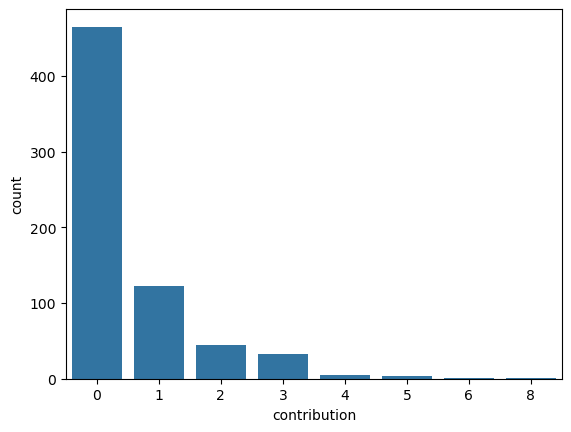

In [4]:
sns.countplot(data=df_refined, x='contribution')
plt.show()

In [5]:
df['contribution'].value_counts()

contribution
0    465
1    123
2     44
3     33
4      5
5      4
6      1
8      1
Name: count, dtype: int64

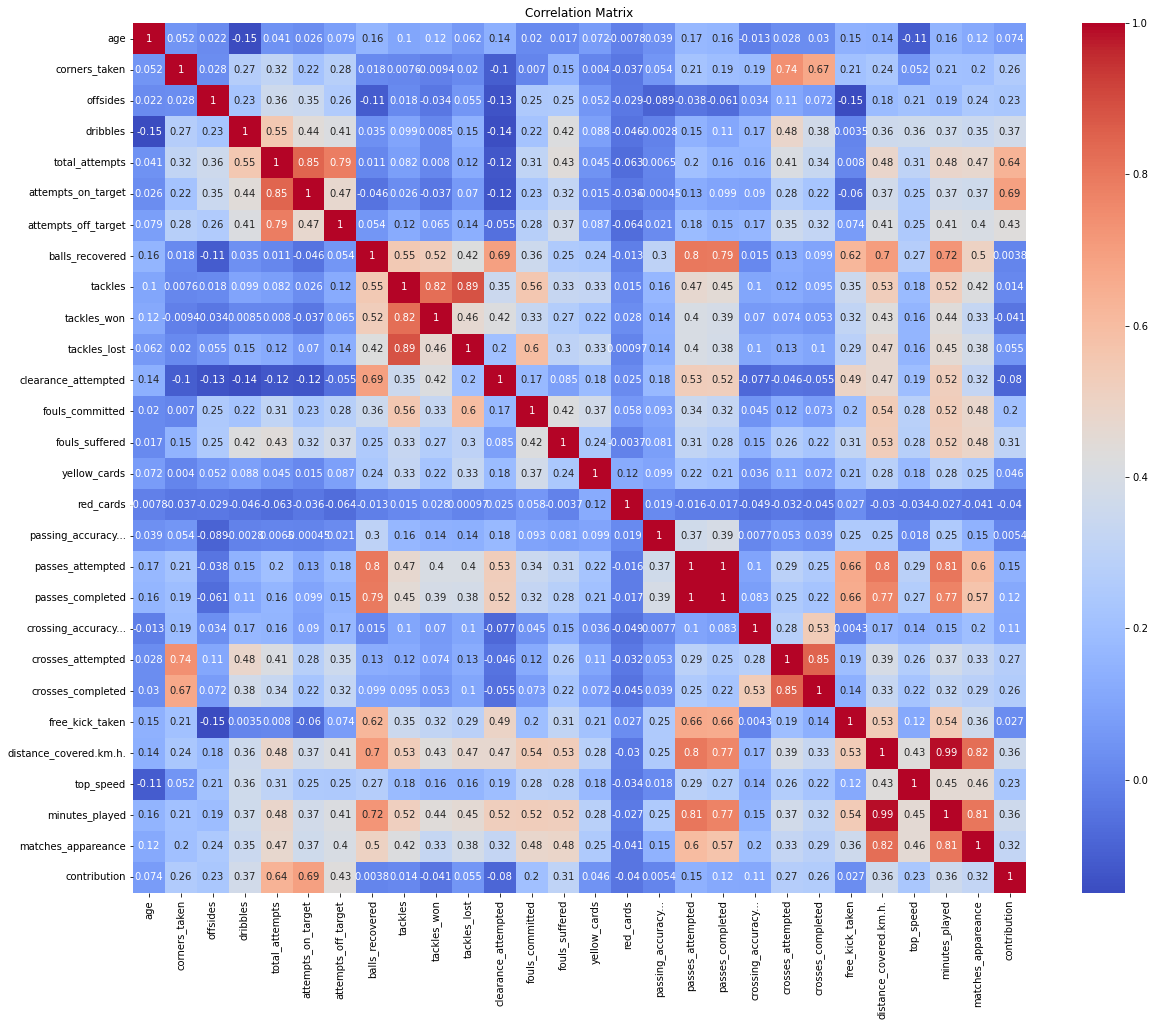

Selected Features: ['dribbles', 'total_attempts', 'attempts_on_target', 'attempts_off_target', 'fouls_suffered', 'distance_covered.km.h.', 'minutes_played', 'matches_appareance', 'contribution']


In [6]:
# Calculate correlation matrix
correlation_matrix = df_refined.corr()

# Plot heatmap for correlation
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Select features with high correlation to the target
target = 'contribution'  # Replace with your target column
correlation_with_target = correlation_matrix[target]
selected_features = correlation_with_target[correlation_with_target.abs() > 0.3].index.tolist()
print("Selected Features:", selected_features)

In [ ]:
correlation_with_target.sort_values()

In [7]:
covariates = ['dribbles', 'total_attempts', 'fouls_suffered', 'distance_covered.km.h.', 'minutes_played', 'field_position', 'contribution']
covariates

['dribbles',
 'total_attempts',
 'fouls_suffered',
 'distance_covered.km.h.',
 'minutes_played',
 'field_position',
 'contribution']

In [8]:
df_final = df_refined[covariates]
df_final = df_final.join(pd.get_dummies(df_final['field_position']))
df_final = df_final.drop(columns=['field_position', 'Defender'])
df_final = df_final.rename(columns={'distance_covered.km.h.': 'distance_covered'})
df_final

,dribbles,total_attempts,fouls_suffered,distance_covered,minutes_played,contribution,Forward,Midfielder
0,1,2,1,22.34,187,1,False,True
1,2,6,4,24.90,177,0,False,True
2,6,1,4,14.68,139,0,False,True
3,1,0,1,31.08,271,0,False,True
4,0,1,1,20.21,165,0,False,False
...,...,...,...,...,...,...,...,...
671,6,1,1,20.45,173,2,False,True
672,4,5,0,17.78,123,0,False,True
673,0,0,0,2.45,15,0,False,True
674,0,1,2,32.21,276,0,False,False


In [9]:
df_final.describe()

,dribbles,total_attempts,fouls_suffered,distance_covered,minutes_played,contribution
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,2.997041,2.763314,2.081361,22.983979,186.162722,0.538462
std,4.411768,3.313749,2.277271,13.948548,117.578973,1.003697
min,0.000000,0.000000,0.000000,0.330000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,10.742500,85.750000,0.000000
50%,1.000000,2.000000,1.000000,22.835000,182.500000,0.000000
75%,4.000000,4.000000,3.000000,35.252500,286.250000,1.000000
max,34.000000,21.000000,11.000000,50.460000,360.000000,8.000000


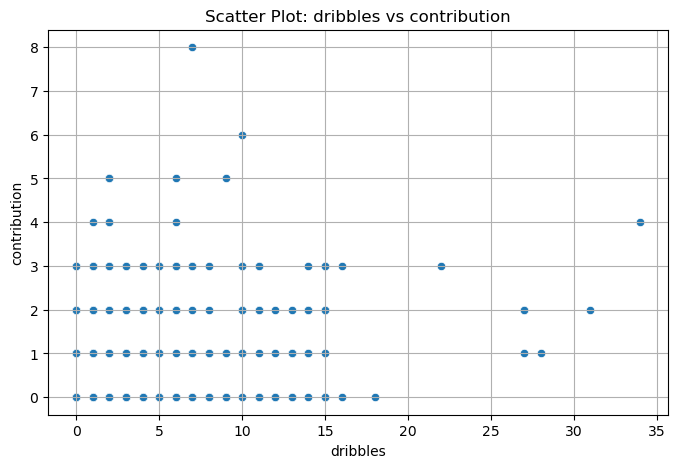

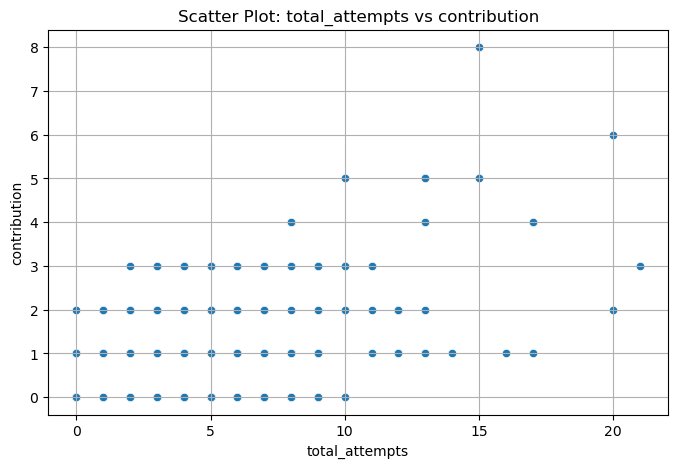

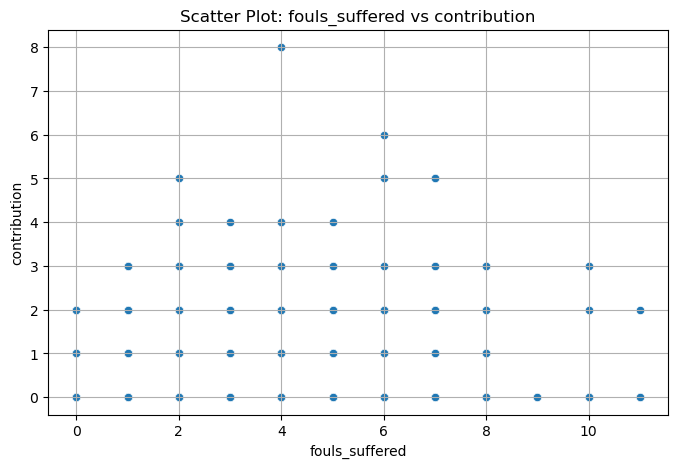

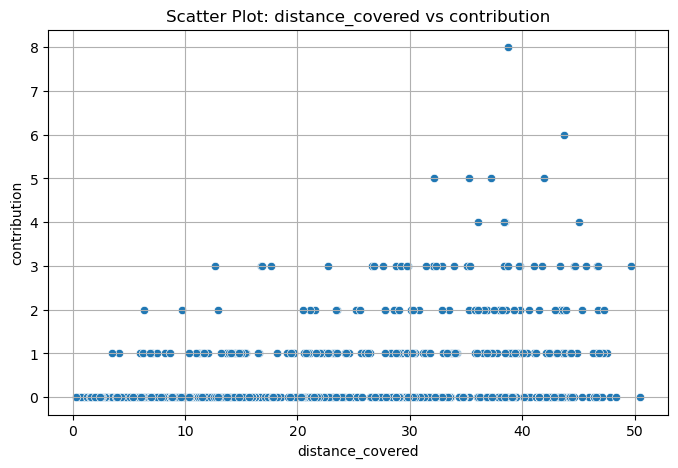

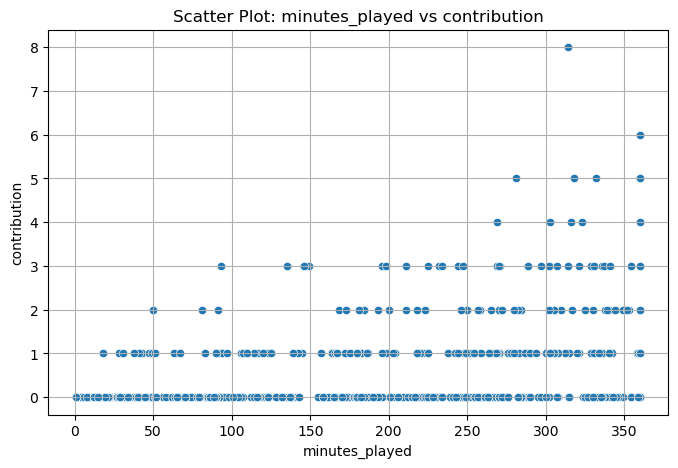

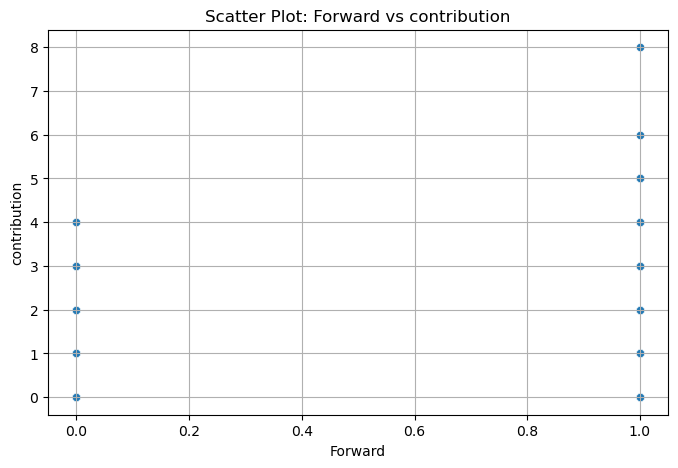

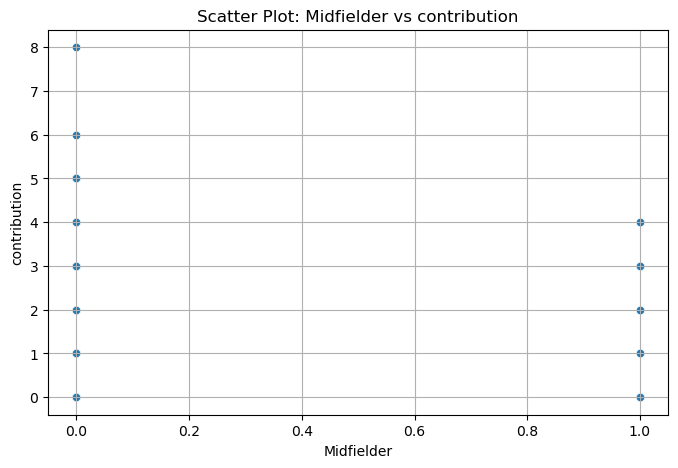

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the target variable and covariates
target = 'contribution'  # Replace with the name of your target variable
covariates = [col for col in df_final.columns if col != target]  # Exclude the target variable

# Loop through covariates to create scatter plots
for covariate in covariates:
    plt.figure(figsize=(8, 5))  # Set figure size
    sns.scatterplot(data=df_final, x=covariate, y=target)
    plt.title(f"Scatter Plot: {covariate} vs {target}")
    plt.xlabel(covariate)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()

In [11]:
df_final.to_csv('final_data.csv')

# Model fit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [contribution]


Output()

<Axes: xlabel='contribution'>

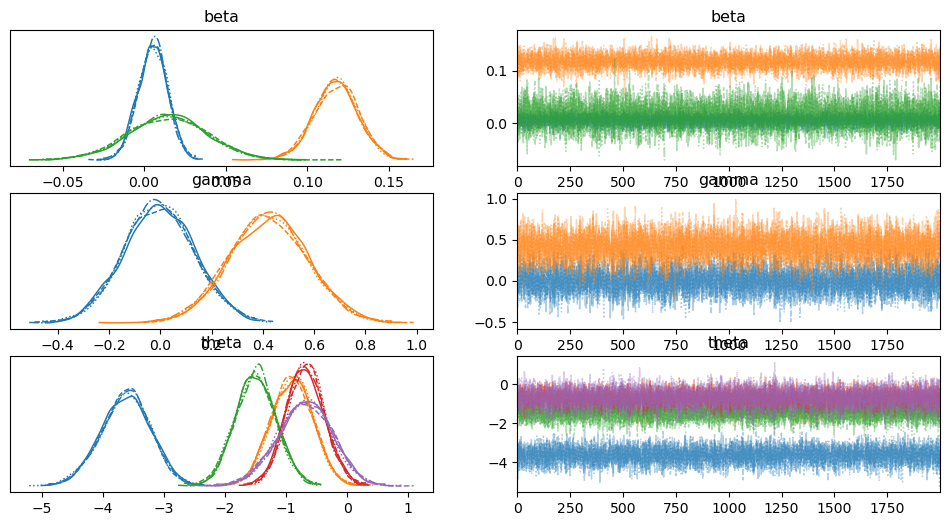

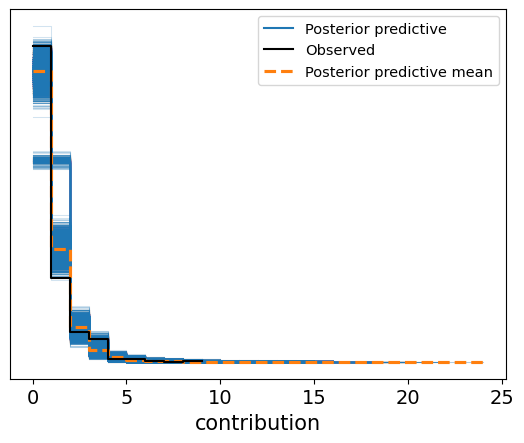

In [12]:
import pymc as pm
from patsy import dmatrix

# Prepare data: Spline basis matrix for distance_covered
distance_spline = dmatrix("bs(distance_covered, df=5, degree=3) - 1", df_final)

with pm.Model() as model:
    # Priors for regression coefficients and spline weights
    beta = pm.Normal("beta", mu=0, sigma=10, shape=3)          # Linear terms (3 predictors)
    gamma = pm.Normal("gamma", mu=0, sigma=10, shape=2)        # Field position effects (2 categories)
    theta = pm.Normal("theta", mu=0, sigma=1, shape=distance_spline.shape[1])  # Spline weights
    
    # Spline effect: Dot product between spline basis matrix and weights
    distance_effect = pm.math.dot(distance_spline, theta)

    # Poisson likelihood: Rate parameter mu modeled as exp(linear combination + spline effect)
    mu = pm.math.exp(
        beta[0] * df_final["dribbles"] +
        beta[1] * df_final["total_attempts"] +
        beta[2] * df_final["fouls_suffered"] +
        distance_effect +
        gamma[0] * df_final['Midfielder'] + 
        gamma[1] * df_final['Forward']
    )
    
    contribution = pm.Poisson("contribution", mu=mu, observed=df_final["contribution"])

    # Sampling from posterior distribution
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Optional: Posterior predictive checks after sampling completes successfully.
with model:
    ppc = pm.sample_posterior_predictive(trace)

import arviz as az

# Summarize results and visualize diagnostics.
az.plot_trace(trace)       # Trace plots for diagnostics.
az.summary(trace)          # Summary statistics.
az.plot_ppc(ppc)           # Posterior predictive checks.

**First plot**: Posterior distribution of estimated parameters

**Second plot**: Trace plot. It show good mixing and convergence properties.

**Third plot**: Posterior Predictive Check (PPC):
- Observed Data (Black Line): represents the histogram (density) of the actual observed values for contribution.
- Posterior Predictive Distribution (Blue Shading): represents the range of predictions generated by your model using posterior samples. darker regions indicating higher probability densities and lighter regions capturing less likely outcomes.
- Posterior Predictive Mean (Orange Dashed Line): represents the mean of the posterior predictive distribution.

In [13]:
az.summary(trace)          # Summary statistics.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.005,0.009,-0.012,0.022,0.000,0.000,8557.0,5741.0,1.0
beta[1],0.118,0.013,0.093,0.143,0.000,0.000,7675.0,5550.0,1.0
beta[2],0.014,0.024,-0.030,0.060,0.000,0.000,7630.0,5187.0,1.0
gamma[0],-0.004,0.137,-0.259,0.258,0.002,0.001,6843.0,6180.0,1.0
gamma[1],0.421,0.151,0.146,0.714,0.002,0.001,6429.0,6181.0,1.0
theta[0],-3.622,0.404,-4.405,-2.884,0.005,0.003,7008.0,6410.0,1.0
theta[1],-0.899,0.343,-1.532,-0.268,0.004,0.003,5943.0,5875.0,1.0
theta[2],-1.498,0.334,-2.124,-0.870,0.004,0.003,5571.0,5770.0,1.0
theta[3],-0.680,0.309,-1.252,-0.091,0.004,0.003,6348.0,5606.0,1.0
theta[4],-0.696,0.442,-1.526,0.120,0.005,0.004,6950.0,5655.0,1.0


**Linear Terms (beta)**: Only "total_attempts" has a strong positive and statistically significant association with contributions.

**Categorical Terms (gamma)**: Being a forward significantly increases contributions compared to baseline players (defenders), while being a midfielder shows no clear difference.

**Spline Terms (theta)**: Increasing distance covered generally decreases contributions, particularly in certain ranges (segments represented by large negative weights like theta[0]). However, at higher ranges (e.g., represented by theta[4]), effects become weaker or insignificant.

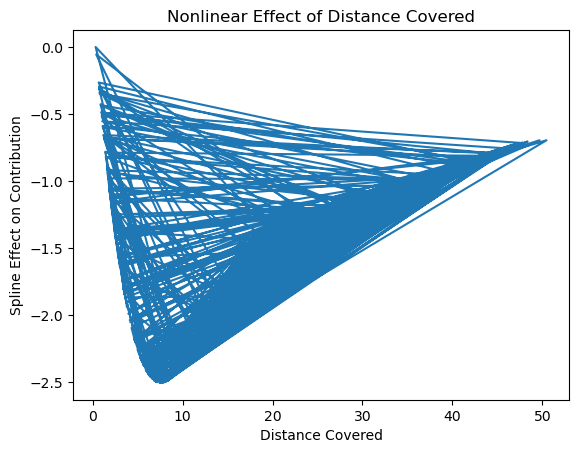

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate spline effect using posterior means
spline_effect = np.dot(distance_spline, trace.posterior['theta'].mean(("chain", "draw")))

# Plot
plt.plot(df_final["distance_covered"], spline_effect)
plt.xlabel("Distance Covered")
plt.ylabel("Spline Effect on Contribution")
plt.title("Nonlinear Effect of Distance Covered")
plt.show()

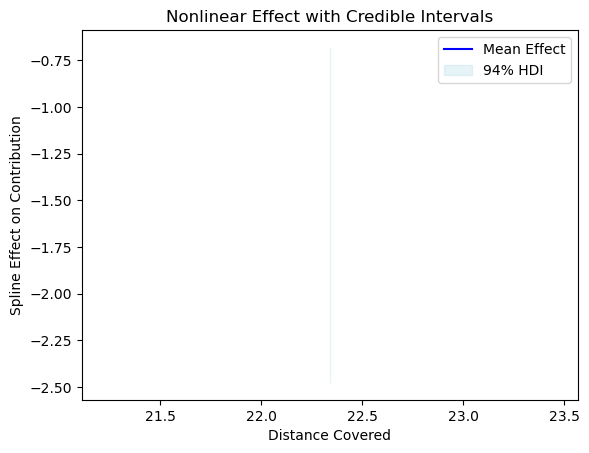

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and HDI for spline effect
mean_spline_effect = np.mean(spline_effect, axis=0)
hdi_lower = np.percentile(spline_effect, 3, axis=0)  # Lower bound of 94% HDI
hdi_upper = np.percentile(spline_effect, 97, axis=0) # Upper bound of 94% HDI

# Ensure x-axis matches y-axis dimensions
x_values = df_final["distance_covered"].values.flatten()[:1]

# Plot mean effect with credible intervals
plt.plot(x_values, mean_spline_effect, label="Mean Effect", color="blue")
plt.fill_between(x_values, hdi_lower, hdi_upper, alpha=0.3,
                 label="94% HDI", color="lightblue")
plt.xlabel("Distance Covered")
plt.ylabel("Spline Effect on Contribution")
plt.title("Nonlinear Effect with Credible Intervals")
plt.legend()
plt.show()